### Libraries used



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/NLP

/content/drive/MyDrive/NLP


In [4]:
ls

 AppReview-Multilabel.csv     'App Reviews-SingleLabel-Multiclass.csv'
'App Reviews-Multilabel.csv'   cc.ar.300.vec


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [6]:
# Set seed
SEED = 777

### Loading data

In [48]:
# Load dataset
df = pd.read_csv("AppReview-Multilabel.csv")
df.head()

,review,bug_report,improvement_request,rating,others
0,يبيله تصليحات كثير,High,Medium,Low,No
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,No,Medium,Medium,Low
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,No,High,Low,No
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,No,No,High,No
4,تبين م لي ي تم ل يب,No,No,Low,High


In [8]:
print(df.describe())

              review bug_report improvement_request rating others
count           2900       2900                2900   2900   2900
unique          2892          4                   4      4      4
top     اكثر من رائع         No                  No   High     No
freq               3       1736                1797    988   2080


## Part-B: Multiclass App Review Classification: from scratch



#### B.1 Lable distribution

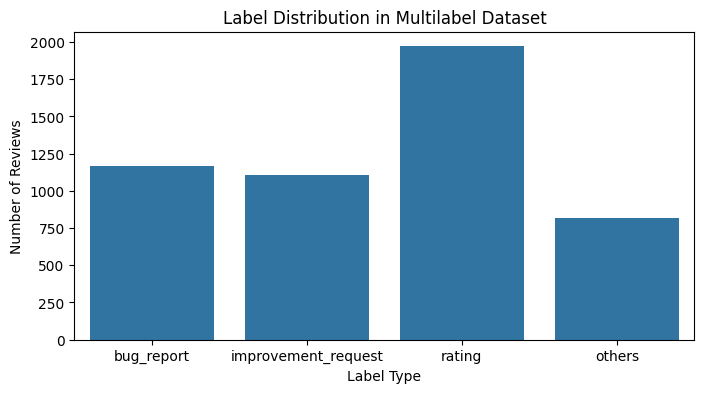

In [49]:
# Count non-"No" values to estimate multilabel counts
class_cols = ['bug_report', 'improvement_request', 'rating', 'others']
label_counts = {}

for col in class_cols:
    label_counts[col] = (df[col] != "No").sum()

# Plot label distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("Label Distribution in Multilabel Dataset")
plt.ylabel("Number of Reviews")
plt.xlabel("Label Type")
plt.show()


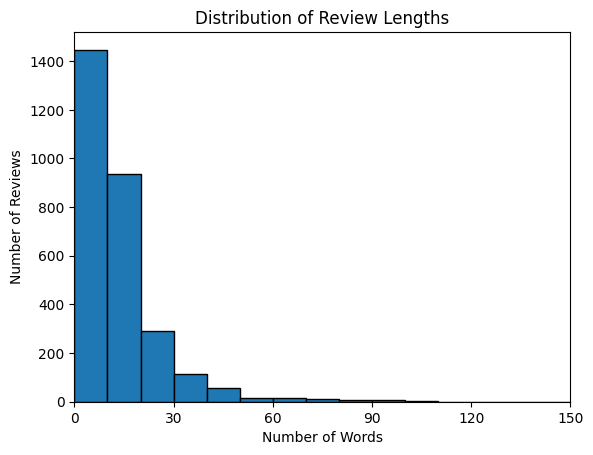


Average Review Length: 13.551724137931034


In [50]:
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))


plt.hist(df['review_length'], bins=range(0, 151, 10), edgecolor="black")  # Adjust bins for better granularity
plt.title("Distribution of Review Lengths")
plt.xlim(0, 150)  # Set x-axis range
plt.xticks(range(0, 151, 30))  # Adjust tick marks
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()

print("\nAverage Review Length:", df['review_length'].mean())



#### B.2 Conversion to multiclass

In [51]:
def assign_single_label(row):
    if row['bug_report'] != 'No':
        return 'bug_report'
    elif row['improvement_request'] != 'No':
        return 'improvement_request'
    elif row['rating'] != 'No':
        return 'rating'
    else:
        return 'others'

df['label'] = df.apply(assign_single_label, axis=1)
df['label'].value_counts()


,count
label,
bug_report,1164
rating,944
improvement_request,595
others,197


#### B.3 Text preprocessing

In [52]:
def preprocess_arabic(text):
    text = str(text)
    # Normalize Arabic characters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    # Remove diacritics
    text = re.sub(r'[\u064B-\u0652]', '', text)

    # Remove repeated characters
    text = re.sub(r'(.)\1+', r'\1\1', text) # kept 2 since some arabic words actually have two repeating letters

    # Remove non-Arabic letters and digits
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing
df['cleaned_review'] = df['review'].apply(preprocess_arabic)
df[['review', 'cleaned_review']].head()

,review,cleaned_review
0,يبيله تصليحات كثير,يبيله تصليحات كثير
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,ماتحملت ابددا ونا دفعت فلوس
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,اتمني منكم عمل خيار لتفضيل المسلسل بالكامل عوض...
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,ممتاز وبسيط وتشغيله لا يوثر علي سرعه الانترنت
4,تبين م لي ي تم ل يب,تبين م لي ي تم ل يب


#### B.4 Label encoding

In [53]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# For reference
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_map)

Label Mapping: {'bug_report': np.int64(0), 'improvement_request': np.int64(1), 'others': np.int64(2), 'rating': np.int64(3)}


#### B.5 Data splitting

In [54]:
# First: Train-Test Split (80-20)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['label_encoded'])

# Second: Validation Split from Train (15% of train)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=SEED, stratify=train_df['label_encoded'])

# Show sizes
print(f"Training Samples: {len(train_df)}")
print(f"Validation Samples: {len(val_df)}")
print(f"Testing Samples: {len(test_df)}")

Training Samples: 1972
Validation Samples: 348
Testing Samples: 580


#### B.6 Tokeniation and padding

In [55]:
# Set parameters
MAX_NUM_WORDS = 10000  # top N words to keep
MAX_SEQUENCE_LENGTH = 120  # max words per review

# Tokenize
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['cleaned_review'])

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['cleaned_review'])
X_val_seq = tokenizer.texts_to_sequences(val_df['cleaned_review'])
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_review'])

# Pad sequences
X_train = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [56]:
# One-hot encode labels
y_train = to_categorical(train_df['label_encoded'])
y_val = to_categorical(val_df['label_encoded'])
y_test = to_categorical(test_df['label_encoded'])

In [57]:
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)}")

Vocabulary size: 8319


#### B.7 Building LSTM model

In [58]:
def plot_history(histories, labels, metric='accuracy'):
    plt.figure(figsize=(8, 6))
    for history, label in zip(histories, labels):
        plt.plot(history.history[metric], label=f"{label} - train")
        plt.plot(history.history[f"val_{metric}"], linestyle='--', label=f"{label} - val")
    plt.title(f"{metric.capitalize()} Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()
    plt.show()

##### B.7.1 LSTM with random embedding

In [59]:
# Parameters
EMBEDDING_DIM_RANDOM = 100  # can be smaller
NUM_CLASSES = y_train.shape[1]

model_random = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM_RANDOM,
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True),  # learn embeddings during training
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

model_random.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_random.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##### B.7.2 LSTM with pretrained embedding

In [ ]:
# Load pretrained FastText embeddings
embedding_index = {}
with open("cc.ar.300.vec", encoding='utf-8') as f:
    next(f)  # skip header
    for line in f:
        values = line.rstrip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors.")

# Build embedding matrix
EMBEDDING_DIM_PRETRAINED = 300
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM_PRETRAINED))

for word, i in tokenizer.word_index.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [60]:
EMBEDDING_DIM_PRETRAINED = 300
embedding_matrix = np.load('embedding_matrix.npy')

In [61]:
# Model 2: Use precomputed FastText vectors
model_pretrained = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM_PRETRAINED,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),  # freeze embeddings
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

model_pretrained.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_pretrained.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

#### B.8 Model training

In [62]:
EPOCHS = 20
BATCH_SIZE = 32

In [63]:
# Train model 1
print("Training Model with Random Embeddings...\n")
history_random = model_random.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Training Model with Random Embeddings...

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 218ms/step - accuracy: 0.3478 - loss: 1.2993 - val_accuracy: 0.4023 - val_loss: 1.2493
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - accuracy: 0.4057 - loss: 1.2464 - val_accuracy: 0.4023 - val_loss: 1.2438
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - accuracy: 0.3898 - loss: 1.2543 - val_accuracy: 0.4023 - val_loss: 1.2410
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - accuracy: 0.3774 - loss: 1.2470 - val_accuracy: 0.4023 - val_loss: 1.2453
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - accuracy: 0.4065 - loss: 1.2413 - val_accuracy: 0.4023 - val_loss: 1.2413
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - accuracy: 0.3968 - loss: 1.2437 - val_accuracy: 0.4023 - val_loss: 1.2409
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 216ms/step - accuracy: 0.4104 - loss: 1.2321 - val_accuracy: 0.4023 - val_loss: 1.2433
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - 

In [65]:
# Train model 2
print("Training Model with Pretrained FastText Embeddings...\n")
history_pretrained = model_pretrained.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Training Model with Pretrained FastText Embeddings...

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 241ms/step - accuracy: 0.3801 - loss: 1.3262 - val_accuracy: 0.4023 - val_loss: 1.2418
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - accuracy: 0.3895 - loss: 1.2528 - val_accuracy: 0.4023 - val_loss: 1.2419
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - accuracy: 0.3914 - loss: 1.2498 - val_accuracy: 0.3994 - val_loss: 1.2449
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - accuracy: 0.4070 - loss: 1.2314 - val_accuracy: 0.4023 - val_loss: 1.2415
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 0.4115 - loss: 1.2341 - val_accuracy: 0.4023 - val_loss: 1.2405
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 0.4016 - loss: 1.2507 - val_accuracy: 0.4023 - val_loss: 1.2469
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - accuracy: 0.3966 - loss: 1.2330 - val_accuracy: 0.4023 - val_loss: 1.2433
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 

In [64]:
loss_random, accuracy_random = model_random.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Random Embeddings): {loss_random:.4f}")
print(f"Test Accuracy (Random Embeddings): {accuracy_random:.4f}")

y_pred_probs = model_random.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)
label_cols = label_encoder.classes_

print("\nMulti-Class Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_cols, zero_division=0))

Test Loss (Random Embeddings): 1.2397
Test Accuracy (Random Embeddings): 0.4017
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step

Multi-Class Classification Report:

                     precision    recall  f1-score   support

         bug_report       0.40      1.00      0.57       233
improvement_request       0.00      0.00      0.00       119
             others       0.00      0.00      0.00        39
             rating       0.00      0.00      0.00       189

           accuracy                           0.40       580
          macro avg       0.10      0.25      0.14       580
       weighted avg       0.16      0.40      0.23       580



In [66]:
loss_pretrained, accuracy_pretrained = model_pretrained.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Pretrained Embeddings): {loss_pretrained:.4f}")
print(f"Test Accuracy (Pretrained Embeddings): {accuracy_pretrained:.4f}")

y_pred_probs = model_pretrained.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)
label_cols = label_encoder.classes_

print("\nMulti-Class Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_cols, zero_division=0))

Test Loss (Pretrained Embeddings): 1.2383
Test Accuracy (Pretrained Embeddings): 0.4017
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step

Multi-Class Classification Report:

                     precision    recall  f1-score   support

         bug_report       0.40      1.00      0.57       233
improvement_request       0.00      0.00      0.00       119
             others       0.00      0.00      0.00        39
             rating       0.00      0.00      0.00       189

           accuracy                           0.40       580
          macro avg       0.10      0.25      0.14       580
       weighted avg       0.16      0.40      0.23       580



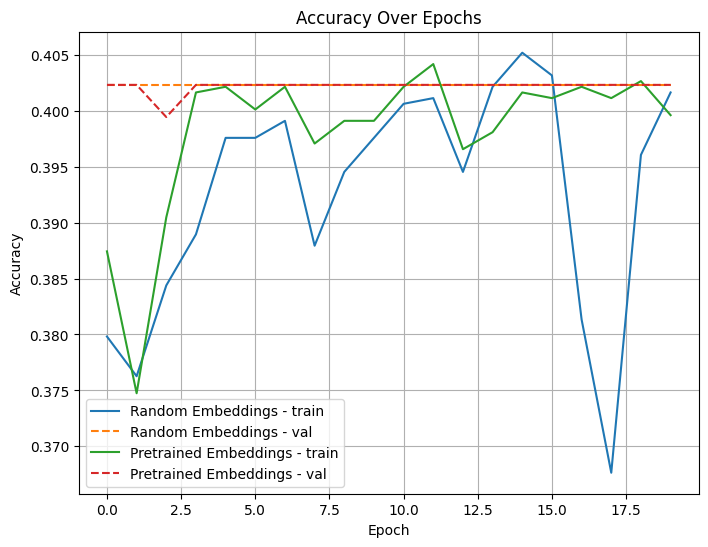

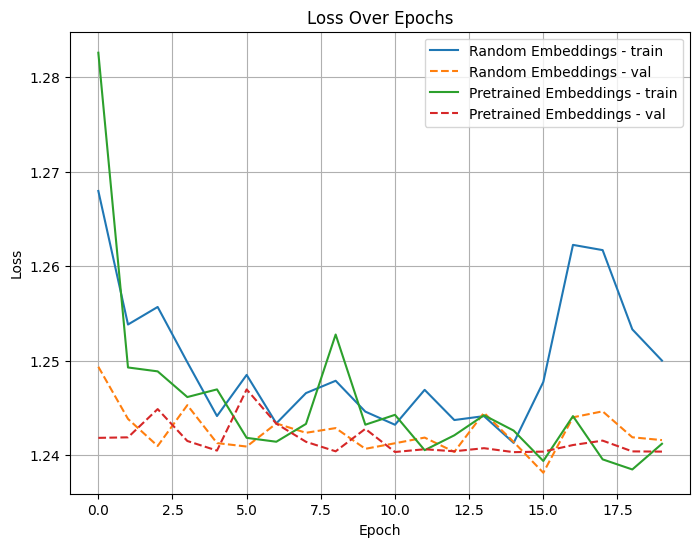

In [67]:
plot_history(
    [history_random, history_pretrained],
    ["Random Embeddings", "Pretrained Embeddings"],
    metric='accuracy'
)

plot_history(
    [history_random, history_pretrained],
    ["Random Embeddings", "Pretrained Embeddings"],
    metric='loss'
)

#### B.9 Classification analysis and possible improvements.

##### B.9.1 Applying oversampling

In [68]:
# Combine features and labels
train_df_combined = train_df[['cleaned_review', 'label_encoded']]

# Separate by class
classes = train_df_combined['label_encoded'].unique()
class_dfs = [train_df_combined[train_df_combined['label_encoded'] == c] for c in classes]

# Find the class with max samples
max_len = max([len(df) for df in class_dfs])

# Oversample minority classes
resampled_dfs = [
    resample(df, replace=True, n_samples=max_len, random_state=SEED)
    if len(df) < max_len else df
    for df in class_dfs
]

# Concatenate back
balanced_train_df = pd.concat(resampled_dfs).sample(frac=1, random_state=SEED)  # shuffle

print("Balanced class counts:")
print(balanced_train_df['label_encoded'].value_counts())

Balanced class counts:
label_encoded
2    791
1    791
3    791
0    791
Name: count, dtype: int64


In [69]:
# Tokenize balanced data
X_train_balanced_seq = tokenizer.texts_to_sequences(balanced_train_df['cleaned_review'])
X_train_balanced = pad_sequences(X_train_balanced_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Labels
y_train_balanced = to_categorical(balanced_train_df['label_encoded'])

##### B.9.2 Modifying the model to use (Oversampled data, BiLSTM, Callback functions)

In [70]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

In [71]:
EMBEDDING_DIM_RANDOM = 100
NUM_CLASSES = y_train.shape[1]

model_os_random = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM_RANDOM,
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

model_os_random.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_os_random.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [72]:
EMBEDDING_DIM_PRETRAINED = 300

model_os_pretrained = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM_PRETRAINED,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

model_os_pretrained.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_os_pretrained.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

In [73]:
EPOCHS = 10
BATCH_SIZE = 32

In [74]:
# Train model with Random Embeddings
print("Training BiLSTM with Random Embeddings...\n")
history_os_random = model_os_random.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Training BiLSTM with Random Embeddings...

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 64s 582ms/step - accuracy: 0.3375 - loss: 1.3439 - val_accuracy: 0.4799 - val_loss: 1.2076 - learning_rate: 0.0010
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 63s 393ms/step - accuracy: 0.8073 - loss: 0.5381 - val_accuracy: 0.6322 - val_loss: 1.0303 - learning_rate: 0.0010
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 399ms/step - accuracy: 0.9721 - loss: 0.1099 - val_accuracy: 0.5891 - val_loss: 1.4200 - learning_rate: 0.0010
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9868 - loss: 0.0447
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 388ms/step - accuracy: 0.9868 - loss: 0.0447 - val_accuracy: 0.6178 - val_loss: 1.5093 - learning_rate: 0.0010
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 386ms/step - accuracy: 0.9973 - loss: 0.0162 - val_accuracy: 0.6092 - val_loss: 1.7580 - learning_rate: 5.0000e-04
Epoch 5: early stopping
Restoring mod

In [75]:
# Evaluate the model with random embeddings on the test data
loss_os_random, accuracy_os_random = model_os_random.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Random Embeddings): {loss_os_random:.4f}")
print(f"Test Accuracy (Random Embeddings): {accuracy_os_random:.4f}")

y_pred_probs = model_os_random.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)
label_cols = label_encoder.classes_

print("Multi-Class Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_cols, zero_division=0))


Test Loss (Random Embeddings): 0.9621
Test Accuracy (Random Embeddings): 0.6431
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step
Multi-Class Classification Report:

                     precision    recall  f1-score   support

         bug_report       0.73      0.70      0.72       233
improvement_request       0.47      0.48      0.48       119
             others       0.40      0.21      0.27        39
             rating       0.67      0.76      0.71       189

           accuracy                           0.64       580
          macro avg       0.57      0.54      0.54       580
       weighted avg       0.64      0.64      0.64       580



In [76]:
# Train model with Pretrained FastText Embeddings
print("Training BiLSTM with Pretrained FastText Embeddings...\n")
history_os_pretrained = model_os_pretrained.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Training BiLSTM with Pretrained FastText Embeddings...

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 47s 427ms/step - accuracy: 0.3267 - loss: 1.3499 - val_accuracy: 0.3994 - val_loss: 1.2729 - learning_rate: 0.0010
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 429ms/step - accuracy: 0.5391 - loss: 1.1003 - val_accuracy: 0.3994 - val_loss: 1.2788 - learning_rate: 0.0010
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 80s 410ms/step - accuracy: 0.6246 - loss: 0.9214 - val_accuracy: 0.4943 - val_loss: 1.1771 - learning_rate: 0.0010
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 425ms/step - accuracy: 0.6785 - loss: 0.8194 - val_accuracy: 0.4684 - val_loss: 1.2318 - learning_rate: 0.0010
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7484 - loss: 0.6620
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
99/99 ━━━━━━━━━━━━━━━━━━━━ 82s 431ms/step - accuracy: 0.7483 - loss: 0.6619 - val_accuracy: 0.5115 - val_loss: 1.2488 - learning_rate: 0.0010
Epoch 6/10
99/99 ━━━━━━━━━━━

In [77]:
# Evaluate the model with pretrained embeddings on the test data
loss_os_pretrained, accuracy_os_pretrained = model_os_pretrained.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Pretrained Embeddings): {loss_os_pretrained:.4f}")
print(f"Test Accuracy (Pretrained Embeddings): {accuracy_os_pretrained:.4f}")


y_pred_probs = model_os_pretrained.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)
label_cols = label_encoder.classes_

print("Multi-Class Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_cols, zero_division=0))

Test Loss (Pretrained Embeddings): 1.0502
Test Accuracy (Pretrained Embeddings): 0.5586
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step
Multi-Class Classification Report:

                     precision    recall  f1-score   support

         bug_report       0.74      0.55      0.63       233
improvement_request       0.40      0.55      0.46       119
             others       0.27      0.56      0.37        39
             rating       0.67      0.57      0.62       189

           accuracy                           0.56       580
          macro avg       0.52      0.56      0.52       580
       weighted avg       0.62      0.56      0.57       580



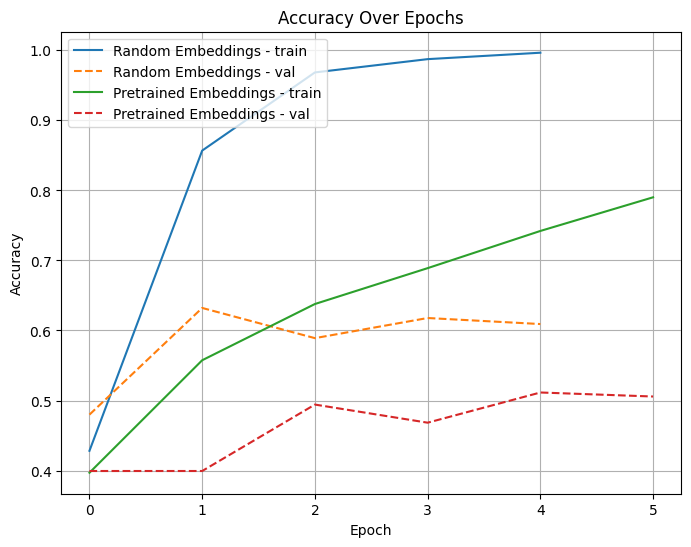

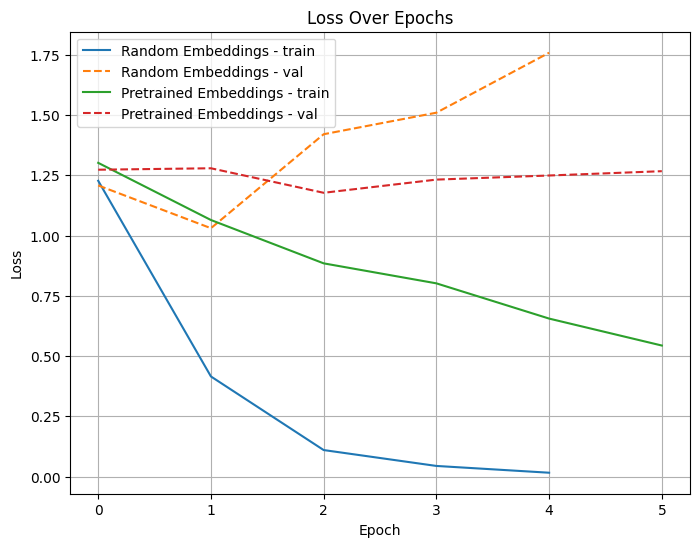

In [78]:
plot_history(
    [history_os_random, history_os_pretrained],
    ["Random Embeddings", "Pretrained Embeddings"],
    metric='accuracy'
)

plot_history(
    [history_os_random, history_os_pretrained],
    ["Random Embeddings", "Pretrained Embeddings"],
    metric='loss'
)

## Part-C: Multilabel App Review Classification: from scratch

### C.1 Loading data

In [79]:
# Load multilabel dataset
df = pd.read_csv("App Reviews-Multilabel.csv")

# Define label columns
label_cols = ['bug_report', 'improvement_request', 'rating', 'others']

#### C.2 Data statistics

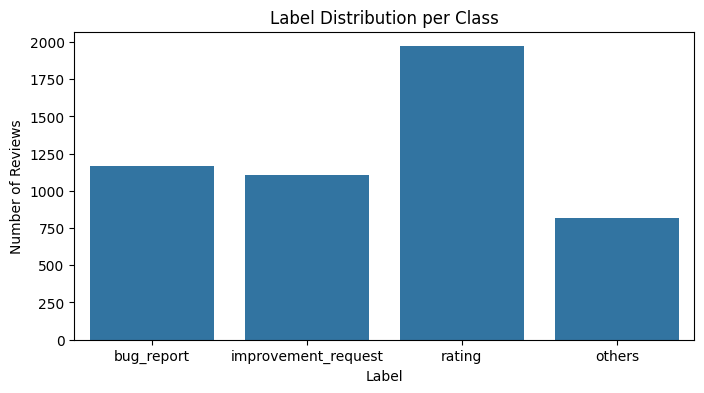


 bug_report             1164
improvement_request    1103
rating                 1971
others                  820
dtype: int64


In [80]:
label_sums = df[label_cols].sum()

plt.figure(figsize=(8, 4))
sns.barplot(x=label_sums.index, y=label_sums.values)
plt.title("Label Distribution per Class")
plt.ylabel("Number of Reviews")
plt.xlabel("Label")
plt.show()

print("\n",label_sums)


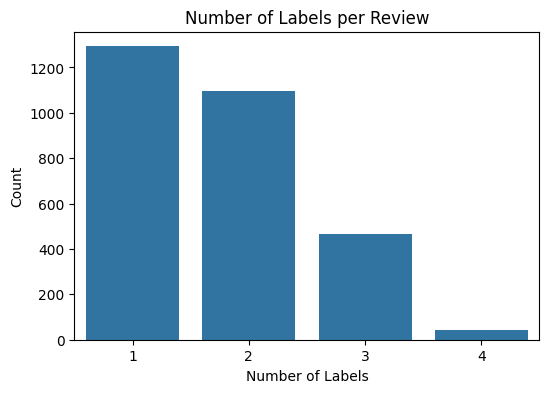

num_labels
1    1293
2    1098
3     467
4      42
Name: count, dtype: int64


In [81]:
df['num_labels'] = df[label_cols].sum(axis=1)

plt.figure(figsize=(6, 4))
sns.countplot(x=df['num_labels'])
plt.title("Number of Labels per Review")
plt.xlabel("Number of Labels")
plt.ylabel("Count")
plt.show()

print(df['num_labels'].value_counts().sort_index())


Average review length: 13.346206896551724
Max review length: 576


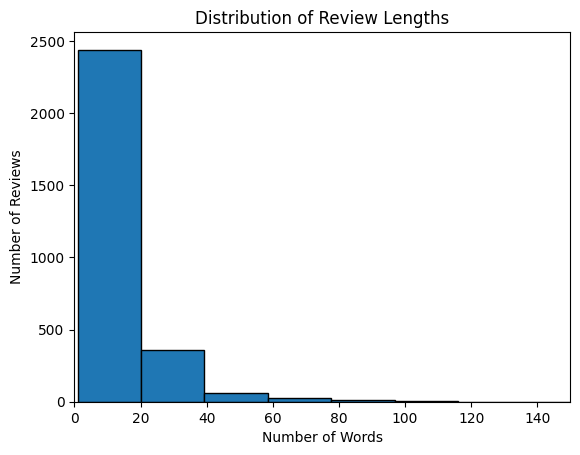

In [84]:
df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))

print("Average review length:", df['review_length'].mean())
print("Max review length:", df['review_length'].max())

plt.hist(df['review_length'], bins=30, edgecolor='black')
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.xlim(0, 150)
plt.show()


#### C.3 Text preprocessing

In [83]:
def preprocess_arabic(text):
    text = str(text)
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    text = re.sub(r'[\u064B-\u0652]', '', text)
    text = re.sub(r'(.)\1+', r'\1\1', text)
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_review'] = df['review'].apply(preprocess_arabic)
df.head()

,review,bug_report,improvement_request,rating,others,num_labels,cleaned_review
0,يبيله تصليحات كثير,1,1,1,0,3,يبيله تصليحات كثير
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,0,1,1,1,3,ماتحملت ابددا ونا دفعت فلوس
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,0,1,1,0,2,اتمني منكم عمل خيار لتفضيل المسلسل بالكامل عوض...
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,0,0,1,0,1,ممتاز وبسيط وتشغيله لا يوثر علي سرعه الانترنت
4,تبين م لي ي تم ل يب,0,0,1,1,2,تبين م لي ي تم ل يب


#### C.4 Data splitting

In [85]:
label_cols = ['bug_report', 'improvement_request', 'rating', 'others']
X_text = df['cleaned_review']
y = df[label_cols].values

# 80-20 train/test
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=SEED)

# 15% val from train
X_train_text, X_val_text, y_train, y_val = train_test_split(X_train_text, y_train, test_size=0.15, random_state=SEED)


#### C.5 Tokenization and padding

In [86]:
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 120

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_text), maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val_text), maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test_text), maxlen=MAX_SEQUENCE_LENGTH, padding='post')

#### C.6 Building BiLSTM model

In [ ]:
embedding_index = {}
with open("cc.ar.300.vec", encoding='utf-8') as f:
    next(f)  # skip header
    for line in f:
        values = line.rstrip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors.")

In [ ]:
# Build embedding matrix
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [88]:
EMBEDDING_DIM = 300
np.save('embedding_matrix.npy', embedding_matrix)


In [89]:
NUM_CLASSES = len(label_cols)

model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='sigmoid')  # multilabel output
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

In [90]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

EPOCHS = 20
BATCH_SIZE = 32

In [91]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 463ms/step - accuracy: 0.3314 - loss: 0.6529 - val_accuracy: 0.4282 - val_loss: 0.5735 - learning_rate: 0.0010
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 475ms/step - accuracy: 0.4559 - loss: 0.5538 - val_accuracy: 0.5029 - val_loss: 0.5096 - learning_rate: 0.0010
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 414ms/step - accuracy: 0.5671 - loss: 0.4741 - val_accuracy: 0.5546 - val_loss: 0.4919 - learning_rate: 0.0010
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 446ms/step - accuracy: 0.5790 - loss: 0.4611 - val_accuracy: 0.5374 - val_loss: 0.4674 - learning_rate: 0.0010
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 450ms/step - accuracy: 0.5854 - loss: 0.4227 - val_accuracy: 0.5718 - val_loss: 0.4603 - learning_rate: 0.0010
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 466ms/step - accuracy: 0.6289 - loss: 0.4026 - val_accuracy: 0.5661 - val_loss: 0.4617 - learning_rate: 0.0010
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 463ms/step - accuracy: 0.6167 - loss: 0.

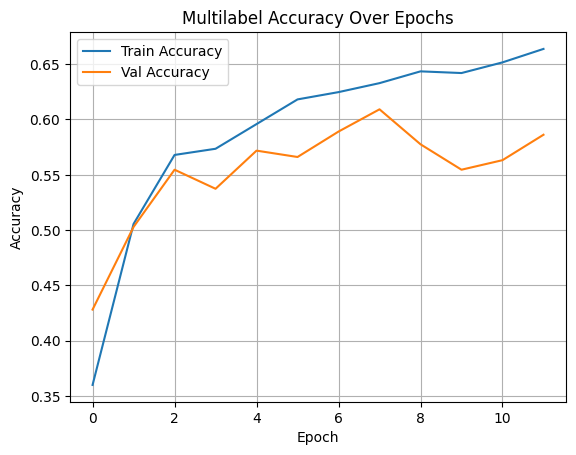

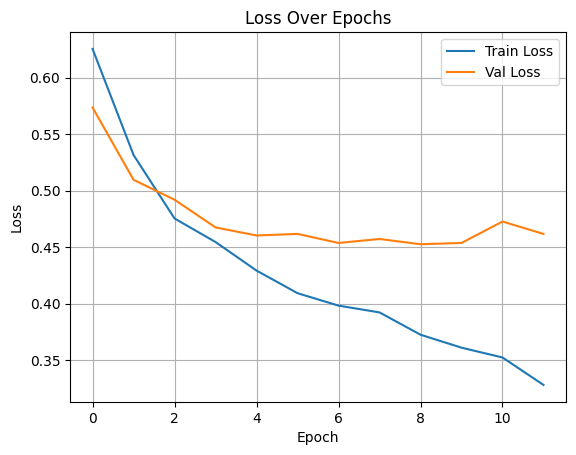

In [92]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Multilabel Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

#### C.7 Model evaluation

In [93]:
# Evaluate the model with pretrained embeddings on the test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Pretrained Embeddings): {loss:.4f}")
print(f"Test Accuracy (Pretrained Embeddings): {accuracy:.4f}")

y_pred_probs = model.predict(X_test)
y_pred_binary = (y_pred_probs >= 0.5).astype(int)  # thresholding

print("Multilabel Classification Report:\n")
print(classification_report(y_test, y_pred_binary, target_names=label_cols, zero_division=0))

Test Loss (Pretrained Embeddings): 0.4654
Test Accuracy (Pretrained Embeddings): 0.5534
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step
Multilabel Classification Report:

                     precision    recall  f1-score   support

         bug_report       0.77      0.77      0.77       239
improvement_request       0.70      0.63      0.66       238
             rating       0.88      0.78      0.82       384
             others       0.65      0.54      0.59       159

          micro avg       0.78      0.70      0.74      1020
          macro avg       0.75      0.68      0.71      1020
       weighted avg       0.78      0.70      0.74      1020
        samples avg       0.81      0.75      0.74      1020



## Part-D: Multiclass App Review Classification: Finetune an MLM

## Part-E: Multilabel App Review Classification: Finetune an MLM

## Part-F: Multiclass App Review Classification: In-Context learning using causal LLM


#### Zero-shot learning

#### Few-shot learning

## Part-G: Multilabel App Review Classification: In-Context learning using causal LLM


#### Zero-shot learning

#### Few-shot learning